# Statistical testing benchmarks
> We have HoroRF benchmarks. Now let's see what we get:

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from scipy.stats import ttest_ind

# Paired t-test
from scipy.stats import ttest_rel

In [126]:
BENCHMARK_PATH = "HoroRF/logs/big_bench/hororf_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_dt_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_n1_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_n12_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md6_n24_results.tsv"

ADD_PM = False

In [278]:
# Group by (n_samples, dataset, dim) and t-test classifier performances across 5 folds


def ttest_table(paths):
    if isinstance(paths, str):
        paths = [paths]

    # benchmarks = pd.read_table(path, index_col=0)  # Slightly updated (no resampling)
    benchmarks = pd.concat([pd.read_table(path, index_col=0) for path in paths])
    benchmarks.loc[benchmarks["dataset"] == "polblogs_hypll", "n_samples"] = 979
    grouped = benchmarks.groupby(["dataset", "dim", "n_samples"])
    ttest_results = []
    order_names = ["rf", "hrf", "hororf"]
    for (dataset, dim, n_samples), group in grouped:
        rf = group.loc[group["clf"] == "rf", "f1_micro"]
        hrf = group.loc[group["clf"] == "hrf", "f1_micro"]
        horo = group.loc[group["clf"] == "hororf", "f1_micro"]

        # t-tests
        rf_vs_hrf = ttest_rel(rf, hrf)
        rf_vs_hrf_sig = "*" if rf_vs_hrf.pvalue < 0.05 else ""
        rf_vs_horo = ttest_rel(rf, horo)
        rf_vs_horo_sig = "*" if rf_vs_horo.pvalue < 0.05 else ""
        hrf_vs_horo = ttest_rel(hrf, horo)
        hrf_vs_horo_sig = "*" if hrf_vs_horo.pvalue < 0.05 else ""

        # What's the order of performance?
        means = [rf.mean(), hrf.mean(), horo.mean()]
        order = np.argsort(means)
        # order_str = " > ".join([order_names[i] for i in order[::-1]])  # Reverse because argsort is ascending
        order_str = order_names[order[-1]]
        for i in order[-2::-1]:
            if np.isclose(means[i], means[order[-1]], atol=1e-4):  # We round off past this
                marker = "="
            else:
                marker = ">"
            order_str += f" {marker} {order_names[i]}"
        # best = order_names[order[-1]]
        best = order_str.split(" > ")[0]
        if best.find("=") > -1:
            best = "{" + ", ".join(best.split(" = ")) + "}"

        # Aggregate results
        ttest_results.append(
            {
                "dataset": dataset,
                "dim": dim,
                "n_samples": n_samples,
                "n_scores": len(rf),
                "order": order_str,
                "best": best,
                "rf": rf.mean() * 100,
                "rf_std": rf.std() * 100,
                "hrf": hrf.mean() * 100,
                "hrf_std": hrf.std() * 100,
                "hororf": horo.mean() * 100,
                "hororf_std": horo.std() * 100,
                "rf_vs_hrf": rf_vs_hrf.pvalue,
                "sig1": rf_vs_hrf_sig,
                "rf_vs_horo": rf_vs_horo.pvalue,
                "sig2": rf_vs_horo_sig,
                "hrf_vs_horo": hrf_vs_horo.pvalue,
                "sig3": hrf_vs_horo_sig,
            }
        )

    ttest_results = pd.DataFrame(ttest_results)
    ttest_results = ttest_results.set_index(["dataset", "dim", "n_samples"])

    return ttest_results


ttest_results = ttest_table(
    # ["data/processed/hororf_benchmarks/md3_dt_results_2.tsv", "data/processed/hororf_benchmarks/md3_dt_results.tsv"]
    ["data/processed/hororf_benchmarks/md3_n12_results_2.tsv", "data/processed/hororf_benchmarks/md3_n12_results.tsv"]
    # ["data/processed/hororf_benchmarks/md6_n24_results.tsv", BENCHMARK_PATH]
)
# ttest_results = ttest_table("data/processed/hororf_benchmarks/md3_dt_results.tsv")
# ttest_results = ttest_table(BENCHMARK_PATH)
ttest_results

n_scores              order           best  \
dataset        dim n_samples                                               
gaussian       2   100              50  hrf > rf > hororf            hrf   
                   200              50  hrf > rf > hororf            hrf   
                   400              50  hrf > rf > hororf            hrf   
                   800              50  hrf > hororf > rf            hrf   
               4   100              50  hrf > rf > hororf            hrf   
                   200              50  hrf > hororf > rf            hrf   
                   400              50  hrf > hororf > rf            hrf   
                   800              50  hrf > hororf > rf            hrf   
               8   100              50  hrf > rf > hororf            hrf   
                   200              50  hororf = hrf > rf  {hororf, hrf}   
                   400              50  rf > hororf > hrf             rf   
                   800              50  hrf > hororf > rf            hrf   
               16  100              50  hrf > hororf > rf            hrf   
                   200              50  rf > hrf > hororf             rf   
                   400              50  hrf = rf > hororf      {hrf, rf}   
                   800              50  hrf > rf > hororf            hrf   
neuroseed      2   100              50  hrf > hororf > rf            hrf   
                   200              50  hororf > hrf > rf         hororf   
                   400              50  hrf > rf > hororf            hrf   
                   800              50  hrf > hororf > rf            hrf   
               4   100              50  hrf > rf > hororf            hrf   
                   200              50  hrf > rf > hororf            hrf   
                   400              50  hrf > rf > hororf            hrf   
                   800              50  hrf > rf > hororf            hrf   
               8   100              50  rf > hrf > hororf             rf   
                   200              50  rf > hrf > hororf             rf   
                   400              50  rf > hrf > hororf             rf   
                   800              50  rf > hrf > hororf             rf   
               16  100              50  hororf > hrf > rf         hororf   
                   200              50  hororf > hrf > rf         hororf   
                   400              50  hororf > rf > hrf         hororf   
                   800              50  hororf > rf > hrf         hororf   
polblogs_hypll 2   979              50  rf > hrf > hororf             rf   
               4   979              50  hrf > rf > hororf            hrf   
               8   979              50  rf > hrf > hororf             rf   
               16  979              50  rf > hrf > hororf             rf   

                                      rf     rf_std         hrf    hrf_std  \
dataset        dim n_samples                                                 
gaussian       2   100         87.500000  11.920228   90.700000  11.066128   
                   200         89.150000   8.535789   90.600000   9.550617   
                   400         89.000000   8.398554   91.325000   8.047254   
                   800         89.325000   7.958799   91.987500   8.462562   
               4   100         97.900000   4.051958   98.400000   3.838580   
                   200         97.900000   3.548498   98.850000   2.270597   
                   400         98.225000   3.518265   99.300000   1.409697   
                   800         98.212500   3.113525   99.362500   1.380266   
               8   100         99.500000   1.515229   99.700000   1.199490   
                   200         99.700000   0.963624   99.750000   0.757614   
                   400         99.925000   0.392045   99.875000   0.455270   
                   800         99.912500   0.252854   99.962500   0.265165   
               16  100         99.600000   1.3702

In [280]:
dt_t1 = ttest_table(
    ["data/processed/hororf_benchmarks/md3_dt_results_2.tsv", "data/processed/hororf_benchmarks/md3_dt_results.tsv"]
)
rf_t1 = ttest_table(
    ["data/processed/hororf_benchmarks/md3_n12_results_2.tsv", "data/processed/hororf_benchmarks/md3_n12_results.tsv"]
)
t_full = pd.concat([dt_t1, rf_t1], axis=1)
# t_full = t_full[["rf_vs_hrf_dt", "rf_vs_horo_dt", "hrf_vs_horo_dt", "rf_vs_hrf_rf", "rf_vs_horo_rf", "hrf_vs_horo_rf"]]
t_full = t_full[["rf_vs_hrf", "rf_vs_horo", "hrf_vs_horo"]]
t_full.columns = [
    "DT vs \hyperdt",
    "DT vs HoroRF",
    "\hyperdt\ vs HoroRF",
    "RF vs \hyperrf",
    "RF vs HoroRF",
    "\hyperrf\ vs HoroRF",
]

t_full.to_latex("data/processed/hororf_benchmarks/md3_dt_pvals.tex", escape=False, sparsify=True, float_format="%.2e")

In [279]:
# Win/tie counts:
def tally_wins(df):
    wins = {"rf": 0, "hrf": 0, "hororf": 0}
    for name, count in df.groupby("order").count()["n_scores"].items():
        name = name.split(" > ")[0]
        for clf in name.split(" = "):
            wins[clf] += count
    return wins


wins = tally_wins(ttest_results)
wins

{'rf': 10, 'hrf': 22, 'hororf': 6}

In [208]:
# Publish as LaTeX table


# Get output path
def latexify(table, add_pm=True):
    sig_lookup1 = {"rf": ["sig1", "sig2"], "hrf": ["sig1", "sig3"], "hororf": ["sig2", "sig3"]}
    sig_lookup2 = {
        ("rf", "sig1"): "*",  # RF beats HRF
        ("rf", "sig2"): "$\dagger$",  # RF beats HoroRF
        ("hrf", "sig1"): "$\ddagger$",  # HRF beats RF
        ("hrf", "sig3"): "$\dagger$",  # HRF beats HoroRF
        ("hororf", "sig2"): "$\ddagger$",  # HoroRF beats RF
        ("hororf", "sig3"): "*",  # HoroRF beats HRF
    }

    # Make everything plus/minus std (or just convert to float)
    table["rf"] = table["rf"].map("{:.2f}".format)
    table["hrf"] = table["hrf"].map("{:.2f}".format)
    table["hororf"] = table["hororf"].map("{:.2f}".format)

    if add_pm:
        table["rf"] += "$\pm$" + table["rf_std"].map("{:.2f}".format)
        table["hrf"] += "$\pm$" + table["hrf_std"].map("{:.2f}".format)
        table["hororf"] += "$\pm$" + table["hororf_std"].map("{:.2f}".format)

    # Add significance markers, bold best score
    for idx, row in table.iterrows():
        best_ids = row["best"].lstrip("{").rstrip("}").split(", ")
        for best_id in best_ids:
            text = f"\\textbf{{{row[best_id]}}}"
            for sig in sig_lookup1[best_id]:
                if row[sig] == "*":
                    text += "\\textsuperscript{" + sig_lookup2[(best_id, sig)] + "}"
            table.loc[idx, best_id] = text

    # Rename datasets cleanly
    table = table.rename(index={"gaussian": "Gaussian", "neuroseed": "NeuroSEED", "polblogs_hypll": "Polblogs"})

    # ttest_latex = ttest_latex.drop(columns=["n_scores", "order", "sig1", "sig2", "sig3", "rf_vs_hrf", "rf_vs_horo", "hrf_vs_horo"])
    table = table[["hrf", "rf", "hororf"]]
    table.columns = ["fastH", "sklearn", "HoroRF"]
    table = table.rename_axis(["Data", "$d$", "$n$"])

    return table


ttest_latex = latexify(ttest_results, add_pm=ADD_PM)
outpath = BENCHMARK_PATH.replace(".tsv", ".tex")
ttest_latex.to_latex(outpath, escape=False, sparsify=True, float_format="%.2f")

In [226]:
# Joint dt + rf
dt_paths = [
    "data/processed/hororf_benchmarks/md3_dt_results.tsv",
    "data/processed/hororf_benchmarks/md3_dt_results_2.tsv",
]
rf_paths = [
    "data/processed/hororf_benchmarks/md3_n12_results.tsv",
    "data/processed/hororf_benchmarks/md3_n12_results_2.tsv",
]
dt_table = latexify(ttest_table(dt_paths), add_pm=ADD_PM)
rf_table = latexify(ttest_table(rf_paths), add_pm=ADD_PM)
merged = pd.merge(dt_table, rf_table, left_index=True, right_index=True, suffixes=("_dt", "_rf"))
merged.columns = ["fastH", "Sklearn", "Horo", "fastH", "Sklearn", "Horo"]

# Make a multiindex for the columns: (Decision Trees, Random Forests) x (fastH, Sklearn, Horo):
merged.columns = pd.MultiIndex.from_product([["Decision Trees", "Random Forests"], ["fastH", "Sklearn", "Horo"]])
merged.to_latex("data/processed/hororf_benchmarks/merged.tex", escape=False, sparsify=True, float_format="%.2f")

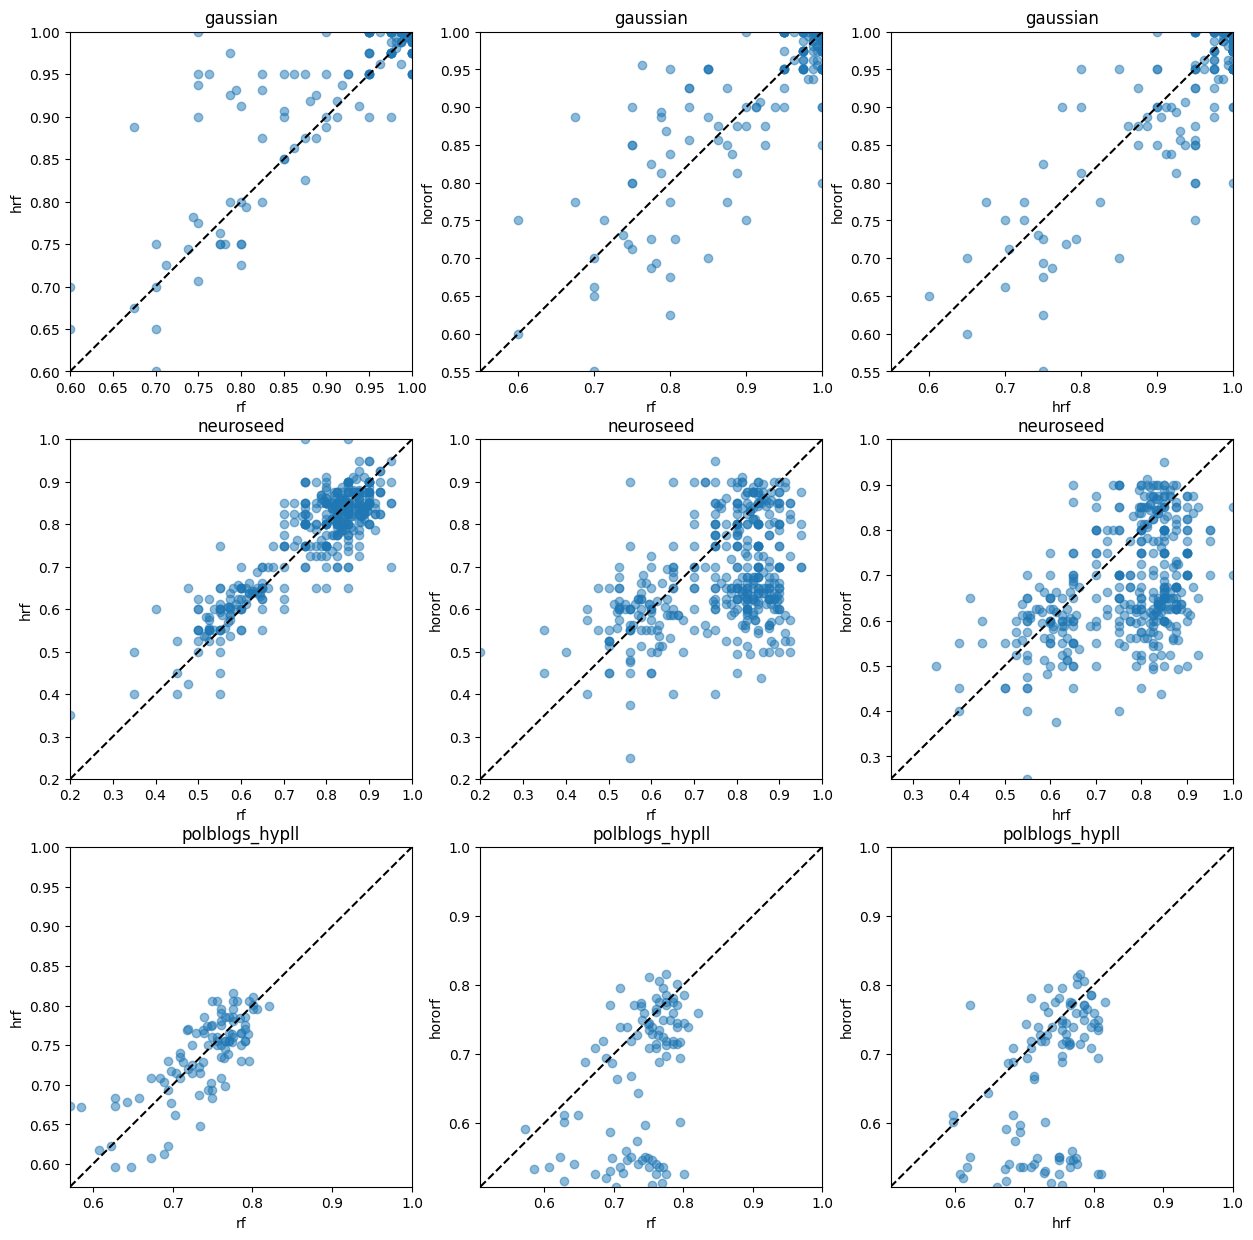

In [84]:
# Scatterplots

datasets = benchmarks["dataset"].unique()
clfs = ["rf", "hrf", "hororf"]
clf_pairs = [("rf", "hrf"), ("rf", "hororf"), ("hrf", "hororf")]
n_datasets = len(datasets)
fig, axs = plt.subplots(3, n_datasets, figsize=(5 * n_datasets, 15))

for i, dataset in enumerate(datasets):
    for j, (clf1, clf2) in enumerate(clf_pairs):
        to_plot = benchmarks.loc[benchmarks["dataset"] == dataset]
        to_plot1 = to_plot.loc[to_plot["clf"] == clf1, "f1_micro"]
        to_plot2 = to_plot.loc[to_plot["clf"] == clf2, "f1_micro"]
        axs[i, j].scatter(to_plot1, to_plot2, alpha=0.5)
        axs[i, j].set_xlabel(clf1)
        axs[i, j].set_ylabel(clf2)
        axs[i, j].set_title(dataset)
        min_all = min(min(to_plot1), min(to_plot2))
        axs[i, j].plot([min_all, 1], [min_all, 1], label="y=x", color="black", linestyle="dashed")
        axs[i, j].set_xlim([min_all, 1])
        axs[i, j].set_ylim([min_all, 1])

plt.show()

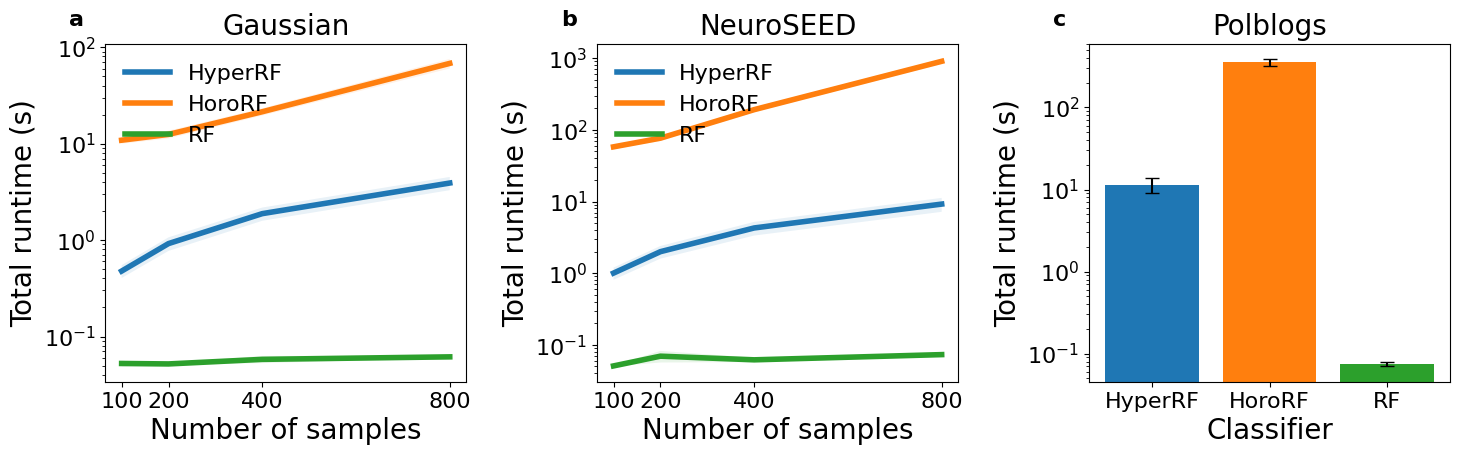

In [3]:
# Times

# times = pd.read_table("HoroRF/logs/big_bench/hororf_times.tsv", index_col=0)
times = pd.read_table("../data/processed/hororf_benchmarks/md3_n12_times_2.tsv", index_col=0)

# For fairness, subtract init time from hororf
times.loc[times["clf"] == "hororf", "time"] -= times.loc[times["clf"] == "hororf", "init_time"]

# Replace hrf data
# hrf_times = pd.read_table("../data/processed/hororf_benchmarks/md3_n12_times_hrf_cached.tsv", index_col=0)
hrf_times = pd.read_table("../data/processed/hororf_benchmarks/md3_n12_times_hrf_cached2.tsv", index_col=0)
times = times[times["clf"] != "hrf"]
times = pd.concat([times, hrf_times])

datasets = times["dataset"].unique()
# clfs = times["clf"].unique()
clfs = ["hrf", "hororf", "rf"]

clf_names = {"rf": "RF", "hrf": "HyperRF", "hororf": "HoroRF"}
dataset_names = {"gaussian": "Gaussian", "neuroseed": "NeuroSEED", "polblogs_hypll": "Polblogs"}

# Set font sizes
plt.rcParams.update({"font.size": 20})
plt.rc("axes", titlesize=20)
plt.rc("axes", labelsize=20)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("legend", fontsize=16)

fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5))

for dataset, ax in zip(datasets, axs):
    data_filtered = times[times["dataset"] == dataset]
    if len(data_filtered["n_samples"].unique()) > 1:
        for clf in clfs:
            to_plot = data_filtered[data_filtered["clf"] == clf]
            means = to_plot.groupby("n_samples")["time"].mean()
            stds = to_plot.groupby("n_samples")["time"].std() / np.sqrt(to_plot.groupby("n_samples")["time"].count())
            ci_upper = means + 1.96 * stds
            ci_lower = means - 1.96 * stds
            ax.plot(means.index, means, label=clf_names[clf], lw=4)
            ax.fill_between(means.index, ci_lower, ci_upper, alpha=0.1)
            # ax.set_xscale("log")
            ax.set_xticks([100, 200, 400, 800])
            ax.set_xticklabels([100, 200, 400, 800])
            ax.minorticks_off()
        ax.set_xlabel("Number of samples")
        ax.legend(loc="upper left", frameon=False)

    else:
        to_plot = data_filtered.groupby("clf")["time"]
        for clf in clfs:
            ax.bar(
                clf_names[clf],
                to_plot.mean()[clf],
                yerr=to_plot.std()[clf] / np.sqrt(to_plot.count()[clf]) * 1.96,
                capsize=5,
            )
        ax.set_xlabel("Classifier")

    # Add labels
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel("Total runtime (s)")
    # ax.set_yscale("log")

    # Label subfigures
    ax.text(
        -0.1,
        1.1,
        chr(ord("a") + list(datasets).index(dataset)),
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
    )
    ax.set_yscale("log")

fig.tight_layout()